## Outer full MSM obtained with milestoning
The unknown parameters are calculated using iteration with a Quasi-Newton method, where the convergence of the MSM is optimized for a given lag time (provided by the inner MSM)

In [84]:
import numpy as np
import pyemma
import matplotlib.pyplot as plt
import pyemma.plots as mplt
import copy
from scipy.interpolate import interp1d 
from scipy.misc import derivative
%matplotlib inline

ideal_tau = 10

In [2]:
# Define class to store trajectories and calculate discrete state trajectories for milestoning
class allTrajs(object):
    
    def __init__(self, Trajs=None, unbinding_r = None, dr = 0.2):
        if Trajs == None:
            Trajs = []
        if ubinding_r == None:
            unbinding_r = 0.3
        if dr == None:
            dr = 0.2
        # Main variables
        self.Trajs = Trajs
        self.unbinding_r = unbinding_r
        self.dr = dr
        self.dTrajs = []
        self.dTrajsclean = []
        self.milestones = {}
        self.milestonesarray = []
        self.regionMap = {}
        # Milestone choice variables
        self.entry_div = 25
        self.exit_div = 25
        # Number of rings in the exit states
        self.rexit_div = 1
        self.rentry1 = 1.8
        self.rentry2 = 2.0
        self.rexit1 = self.rentry2 + self.unbinding_r
        self.rexit2 = self.rexit1 + self.dr
        # Calculated variables:
        # Angular increments
        self.angint_entry = 2*np.pi/self.entry_div
        self.angint_exit = 2*np.pi/self.exit_div
        # Radial increment
        self.rint_exit = (self.rexit2-self.rexit1)/float(self.rexit_div)
    
    # Get discretized trajectories (dTrajs) in chosen milestones 
    # from continue trajectories (Trajs)
    def getdTrajs(self):
        # Resize dTrajs array 
        self.dTrajs = [None] * len(self.Trajs)
        # Loop over each trajectory
        for i in range(len(self.Trajs)):
            # Create empty list of consistent size for ith discrete trajectory
            trajlen = len(self.Trajs[i])
            self.dTrajs[i] = [None] * trajlen
            # Loop over each time iteration to set corresponding discrete state
            for j in range(trajlen):
                if j > 0:
                    prevstate = self.dTrajs[i][j-1]
                else:
                    prevstate = None
                self.dTrajs[i][j] = self.getState(self.Trajs[i][j],prevstate)
        return self.dTrajs
    
    # Same a getdTrajs but ensuring there are no "None" states,
    # since they can appear if the initial condition is in a "None" state region
    def getdTrajsclean(self):
        # If dTrajs haven't been yet calculated, do so
        if self.dTrajs == []:
            self.getdTrajs()
        self.dTrajsclean = copy.deepcopy(self.dTrajs)
        # Eliminate "None" entries in reverse order to avoid misindexing
        for i in reversed(range(len(self.dTrajs))):
            if self.dTrajs[i] == None:
                self.dTrajsclean.pop(i)
            else:
                for j in reversed(range(len(self.dTrajs[i]))):
                    if self.dTrajs[i][j] == None:
                        self.dTrajsclean[i].pop(j)
            if self.dTrajsclean[i] == []:
                self.dTrajsclean.pop(i)
        return self.dTrajsclean
                        
    
    # Given coordinates, assigns a state which corresponds to an area
    # in space. The state is assigned with an integer value. The center of the
    # state region is given by getMilestones() function
    def getState(self, coord, prevst):
        x = coord[0]
        y = coord[1]
        r = np.sqrt(x*x + y*y)
        th = np.arctan2(y, x)
        # Bound state
        if r <= 1.:
            state = 0
            return state
        # Entry states
        elif (r >= self.rentry1 and r < self.rentry2):
            for k in range(self.entry_div):
                llim = -np.pi + k*self.angint_entry
                rlim = -np.pi + (k+1)*self.angint_entry
                if (th >= llim and th < rlim):
                    state = k + 1
                    return state
        # Exit states
        elif (r >= self.rexit1 and r <= self.rexit2):
            # Check in which ring the particle is
            for j in range(self.rexit_div):
                rincrement = (self.rexit2 - self.rexit1)/float(self.rexit_div)
                if (r >= self.rexit1 + j*self.rint_exit and r <= self.rexit1 + (j+1)*self.rint_exit):
                    for k in range(self.exit_div):
                        llim = -np.pi + k*self.angint_exit
                        rlim = -np.pi + (k+1)*self.angint_exit
                        if (th >= llim and th < rlim):
                            state = self.entry_div + j*self.exit_div + k + 1
                            return state
        # Bath state
        elif (r > self.rexit2):
            state = self.entry_div + self.rexit_div*self.exit_div + 1
            return state
        # Didn't change state
        else:
            state = prevst
            return state
    
    # Get x,y centers of milestones in a dictionary: milestones[state] = [x,y]    
    def getMilestones(self):
        # Bound state is 0 and assigned origin as center
        self.milestones[0] = [0.0,0.0]
        rentry = (self.rentry1 + self.rentry2)/2.0
        # Loop over entry states
        for k in range(self.entry_div):
            llim = -np.pi + k*self.angint_entry
            rlim = -np.pi + (k+1)*self.angint_entry
            th = (rlim + llim)/2.0
            x = rentry*np.cos(th)
            y = rentry*np.sin(th)
            self.milestones[k+1] = [x,y]
        # Loope over exit states
        for j in range(self.rexit_div):
            for k in range(self.exit_div):
                llim = -np.pi + k*self.angint_exit
                rlim = -np.pi + (k+1)*self.angint_exit
                th = (rlim + llim)/2.0
                rexit = self.rexit1 + (j+0.5)*self.rint_exit
                x = rexit*np.cos(th)
                y = rexit*np.sin(th)
                self.milestones[k + 1 + self.entry_div + j*self.exit_div] = [x,y]
        self.milestones[self.entry_div + self.rexit_div*self.exit_div + 1] = [2.5,2.5] # Change if dim of system changes
        return self.milestones
    
    # Get milestones centers in array for plotting
    def getMilestonesArray(self):
        if self.milestones == {}:
            self.getMilestones()
        self.milestonesarray = np.zeros((len(self.milestones),2))
        for i in range(len(self.milestones)):
            self.milestonesarray[i][0] = self.milestones[i][0]
            self.milestonesarray[i][1] = self.milestones[i][1]
        return self.milestonesarray
    
    # Calculate State discretization parameters into a dictionary to place  
    # uniformly theparticle in the exit states in the hybrid model
    def getRegionMap(self):
        self.regionMap[0] = 'Bound'
        # Add entry states to dictionary
        for k in range(self.entry_div):
            llim = -np.pi + k*self.angint_entry
            rlim = -np.pi + (k+1)*self.angint_entry
            self.regionMap[k+1] = [[llim,rlim],[self.rentry1, self.rentry2]]
        # Add exit states to dictionary
        for j in range(self.rexit_div):
            for k in range(self.exit_div):
                llim = -np.pi + k*self.angint_exit
                rlim = -np.pi + (k+1)*self.angint_exit
                rllim = self.rexit1 + j*self.rint_exit
                rrlim = self.rexit1 + (j+1)*self.rint_exit
                self.regionMap[k + 1 + self.entry_div + j * self.exit_div] = [[llim, rlim],[rllim, rrlim]]
        # Add exit states radii interval
        self.regionMap['rexit_int'] = [self.rexit1, self.rexit2]
        self.regionMap['rentry_int'] = [self.rentry1, self.rentry2]
        return self.regionMap

In [4]:
# Define filter for trajectory extraction from file
def filter(f, stride):
    for i, line in enumerate(f):
        if (not i%stride):
            yield line
# Extract trajectories from file using allTrajs class
fname = '../data/2DmodifiedLJmultipleTrajsLongR4.txt'
alltrajs = allTrajs([]) # define allTrajs object
dimension = 2
with open(fname) as f:
    data = np.genfromtxt(filter(f, 1))
    ntrajs = data.shape[1]/dimension
    for i in range(0, ntrajs):
        traj = data[:,2*i:2*i+dimension]
        alltrajs.Trajs.append(traj)

In [5]:
# Calculate discrete trajectories and make sure it is clean (no "None" elements)
dtrajs = alltrajs.getdTrajsclean()
# Obtain centers of each state and save
centersdict = alltrajs.getMilestones()
centers = alltrajs.getMilestonesArray()

In [6]:
# Obtained implied time scales using pyemma
its = pyemma.msm.its(dtrajs, lags = 100)

estimating MaximumLikelihoodMSM: 100% (11/11) [####################] eta 00:00 |

(array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.]),
 <a list of 9 Text yticklabel objects>)

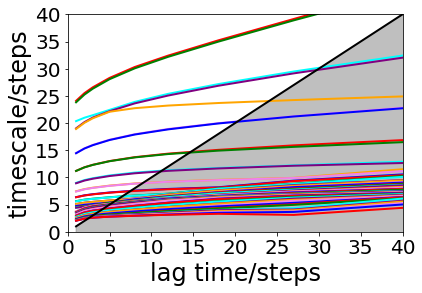

In [9]:
# Plot implied time scales
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2, dt=1)
plt.ylabel(r"timescale/steps", fontsize = 24)
plt.xlabel(r"lag time/steps", fontsize = 24)
plt.xlim(0,40)
plt.ylim(0,40)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

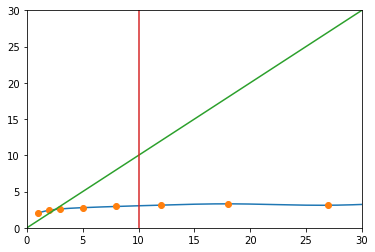

In [106]:
# Obtain and interpolate curve for smallest timescale
taus = its.lags
ntimescales = its.number_of_timescales
smallest_tscale = its.get_timescales(process=ntimescales-1)
f_smallest_tscale = interp1d(taus, smallest_tscale, kind='cubic')
# Plot interpolated curve
taus_int = np.arange(1,80,0.01)
plt.plot(taus_int, f_smallest_tscale(taus_int))
plt.plot(taus, smallest_tscale,'o')
plt.plot([0,80],[0,80])
plt.plot([ideal_tau,ideal_tau], [0,80])
plt.xlim(0,30)
plt.ylim(0,30)
# Calulate intersection with ideal lag time
intersection = f_smallest_tscale(ideal_tau)-0.0

In [110]:
derivmean = 0
for i in range(ntimescales):
    tscale = its.get_timescales(process=i)
    f_tscale = interp1d(taus, tscale, kind='cubic')
    diff = derivative(f_tscale, x0 = ideal_tau, dx = 0.001)
    derivmean = derivmean + diff

derivmean = derivmean/ntimescales
optfunc = derivmean + (ideal_tau - intersection)/ntimescales
print derivmean, optfunc
    

0.152769584114 0.289242459394


In [45]:
# Choose lag time and obtain MSM "M" for our milestones
msm_lag = 2
M = pyemma.msm.estimate_markov_model(dtrajs, msm_lag, reversible=True)

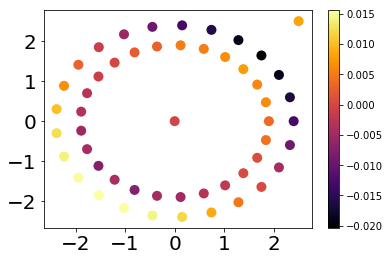

In [79]:
# Plot states and color them according to their weight in a given eigenmode
eigenmode =  27 # 0 = stationary distribution
vectors = M.eigenvectors_left()
value = M.eigenvalues()
#print M.timescales()[:10] 
#print -msm_lag/np.log(value[1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sc = plt.scatter(centers[:,0], centers[:,1], c=vectors[eigenmode][:], cmap=plt.cm.inferno, linewidths = 0, s=100)
plt.colorbar()